In [1645]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd
import data_extraction

import ARIMA
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [1646]:
def ANN_train(X_train, y_train, hidden_layers, alpha=1e-5, random_state=1):
    '''
    INPUT:
    timeseries: TYPE: DataFrame. Contains column named 'residual'
    q: TYPE: Integer. Decides how many historical values to consider
    hidden_layers: TYPE: Tuple of integers. The number on the i'th position decides number of nodes in hidden layer i

    OUTPUT:
    Returns trained model: TYPE: MLPRegressor
    '''
    model = MLPRegressor(solver="lbfgs", 
                         alpha=alpha, 
                         hidden_layer_sizes=hidden_layers, 
                         random_state=random_state, 
                         max_iter=20000,
                         #learning_rate = "adaptive",
                         tol=1e-20) #default tolerance
    model.fit(X_train, y_train)
    return model

In [1647]:
past_weeks = 3
hidden_layers = (2,1)
nRowsRead = None
grid_number = 1

df = pd.read_pickle('forecast1.pkl')

def to_datetime(string):
    return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")


def to_string(date):
    return datetime.strftime(date, "%Y-%m-%d %H:%M:%S")


In [1648]:
df['residuals'].size

12902

In [1649]:
def data_ANN(past_weeks, df):
    # input values
    # past_vals is the number of past values of the residuals that the ANN will use
    residuals = df["residuals"]

    X = []
    y = []
    
    for i in tqdm(range(len(residuals.values) - past_weeks*24*7)):
        X_el = residuals[i:i+24*7*past_weeks:24*7]
        X.append(X_el)
        y.append([residuals.iloc[i+past_weeks*24*7]])
    
    return X, y


In [1650]:
X, y = data_ANN(past_weeks, df)
X

100%|██████████| 12398/12398 [00:05<00:00, 2281.02it/s]


[2018-12-09 01:00:00   -0.021376
 2018-12-16 01:00:00   -0.940249
 2018-12-23 01:00:00   -0.587236
 Name: residuals, dtype: float64,
 2018-12-09 02:00:00    0.077499
 2018-12-16 02:00:00   -1.918331
 2018-12-23 02:00:00   -0.688400
 Name: residuals, dtype: float64,
 2018-12-09 03:00:00   -0.054471
 2018-12-16 03:00:00   -1.945686
 2018-12-23 03:00:00   -0.680757
 Name: residuals, dtype: float64,
 2018-12-09 04:00:00   -1.096991
 2018-12-16 04:00:00   -2.234895
 2018-12-23 04:00:00   -0.083074
 Name: residuals, dtype: float64,
 2018-12-09 05:00:00   -0.316724
 2018-12-16 05:00:00   -2.541499
 2018-12-23 05:00:00    1.112864
 Name: residuals, dtype: float64,
 2018-12-09 06:00:00    1.149710
 2018-12-16 06:00:00   -0.686006
 2018-12-23 06:00:00    2.846259
 Name: residuals, dtype: float64,
 2018-12-09 07:00:00    3.306730
 2018-12-16 07:00:00    2.390112
 2018-12-23 07:00:00    5.096294
 Name: residuals, dtype: float64,
 2018-12-09 08:00:00    3.168794
 2018-12-16 08:00:00    1.285415
 20

In [1651]:
train_size_percentage = 0.50

train_size = int(len(X)*train_size_percentage)
#print(len(data_extraction.get_timeseries("train", nRowsRead, 'loss', grid_number))/(24*7))

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

X_test

[2019-08-24 08:00:00   -1.774763
 2019-08-31 08:00:00   -2.572242
 2019-09-07 08:00:00   -1.994941
 Name: residuals, dtype: float64,
 2019-08-24 09:00:00   -1.450548
 2019-08-31 09:00:00   -2.144197
 2019-09-07 09:00:00   -1.466746
 Name: residuals, dtype: float64,
 2019-08-24 10:00:00   -1.897370
 2019-08-31 10:00:00   -1.232805
 2019-09-07 10:00:00   -1.923613
 Name: residuals, dtype: float64,
 2019-08-24 11:00:00   -1.870763
 2019-08-31 11:00:00   -1.089860
 2019-09-07 11:00:00   -2.483904
 Name: residuals, dtype: float64,
 2019-08-24 12:00:00   -1.399364
 2019-08-31 12:00:00   -1.042513
 2019-09-07 12:00:00   -2.058485
 Name: residuals, dtype: float64,
 2019-08-24 13:00:00   -0.316405
 2019-08-31 13:00:00   -0.965006
 2019-09-07 13:00:00   -1.508624
 Name: residuals, dtype: float64,
 2019-08-24 14:00:00    0.002385
 2019-08-31 14:00:00   -0.384457
 2019-09-07 14:00:00   -1.030990
 Name: residuals, dtype: float64,
 2019-08-24 15:00:00    0.629776
 2019-08-31 15:00:00    0.482142
 20

In [1652]:
model = ANN_train(X_train, y_train, hidden_layers)

In [1653]:
def ANN_pred(model, X_test,X,y):
    X_test = X_test.copy()
    y_test = []
    for i in tqdm(range(len(X_test))):
        X_test_el = X_test[i].values
        val = model.predict(X_test_el.reshape(1,-1))
        y_test.append(val[0])
        #if i%24==0 and i!= len(X_test)-24:
        #    model = ANN_train(X[:train_size+i], y[:train_size+i],hidden_layers)
    return y_test



In [1654]:
y_pred = ANN_pred(model, X_test,X,y)

100%|██████████| 6199/6199 [00:01<00:00, 4950.79it/s]


<AxesSubplot:>

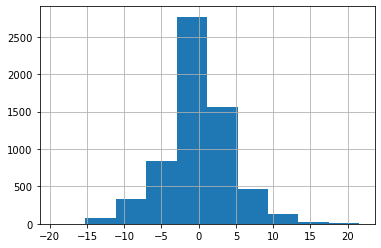

In [1655]:
temp = df.copy()
temp['pred_residuals'] = np.nan
temp['pred_residuals'].iloc[-len(y_pred):] = y_pred
(temp['residuals']-temp['pred_residuals']).dropna().hist()

<AxesSubplot:>

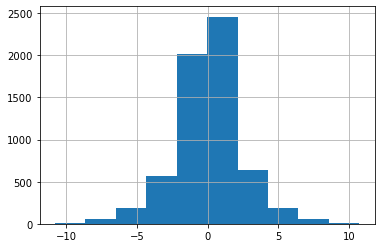

In [1656]:
temp["pred_residuals"].hist()

In [1657]:
df_from_ANN = pd.read_pickle('ANN_forecast.pkl')

In [1658]:
df_from_ANN

,grid1-loss,pred,diff,ann_sum_error,ann_cumsum
2019-12-01 00:00:00,21.55210,23.381831,-1.829731,1.829731,1.829731
2019-12-01 01:00:00,20.71190,22.833866,-2.121966,2.121966,3.951697
2019-12-01 02:00:00,20.27340,22.120645,-1.847245,1.847245,5.798942
2019-12-01 03:00:00,20.25370,21.885621,-1.631921,1.631921,7.430863
2019-12-01 04:00:00,20.40550,21.957250,-1.551750,1.551750,8.982613
...,...,...,...,...,...
2020-05-30 19:00:00,8.55980,15.468094,-6.908294,6.908294,24390.856755
2020-05-30 20:00:00,6.95209,15.331099,-8.379009,8.379009,24399.235764
2020-05-30 21:00:00,8.11558,15.219629,-7.104049,7.104049,24406.339813
2020-05-30 23:00:00,7.26431,14.825960,-7.561650,7.561650,24413.901463


In [1659]:
temp = temp.dropna()

temp['Hybrid'] = temp['ARIMA']+temp['pred_residuals']
temp['ANN'] = df_from_ANN['pred']

temp['arima_sum_error'] = abs(temp['grid-loss'] - temp['ARIMA'])
temp['hybrid_sum_error'] = abs(temp['grid-loss'] - temp['Hybrid'])
temp['ann_sum_error'] = df_from_ANN['ann_sum_error']

temp['arima_cumsum'] = temp['arima_sum_error'].cumsum()
temp['hybrid_cumsum'] = temp['hybrid_sum_error'].cumsum()
temp['error_in_res'] = (temp['residuals']-temp['pred_residuals'])
temp['ann_cumsum'] = df_from_ANN['ann_sum_error'].iloc[-train_size:].cumsum()

<AxesSubplot:>

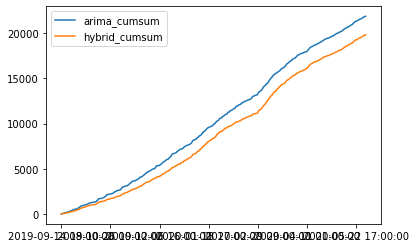

In [1660]:
temp[['arima_cumsum','hybrid_cumsum']].plot()


In [1661]:
(temp['arima_cumsum'].iloc[-1]-temp['hybrid_cumsum'].iloc[-1])/temp['arima_cumsum'].iloc[-1]

0.0945202733269877

<AxesSubplot:>

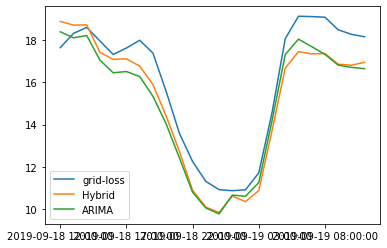

In [1662]:
temp[['grid-loss','Hybrid','ARIMA']].iloc[100:124].plot()

In [1663]:
diff = temp['grid-loss']-temp['Hybrid']
mse_hybrid = (diff**2).mean()

In [1664]:
diff = temp['grid-loss']-temp['ARIMA']
mse_arima = (diff**2).mean()



In [1665]:
(mse_arima-mse_hybrid)/mse_arima

0.1917116047878028

In [1666]:
abs(temp['error_in_res']).cumsum()

2019-09-14 08:00:00        1.726503
2019-09-14 09:00:00        2.699850
2019-09-14 10:00:00        3.559467
2019-09-14 11:00:00        4.737903
2019-09-14 12:00:00        6.234828
                           ...     
2020-05-30 19:00:00    19795.660000
2020-05-30 20:00:00    19796.301372
2020-05-30 21:00:00    19797.422666
2020-05-30 23:00:00    19802.720496
2020-05-31 00:00:00    19805.835230
Name: error_in_res, Length: 6199, dtype: float64

<AxesSubplot:>

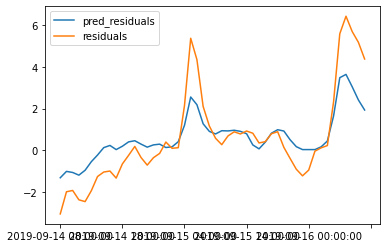

In [1667]:
temp[['pred_residuals','residuals']].iloc[:50].plot()

<AxesSubplot:>

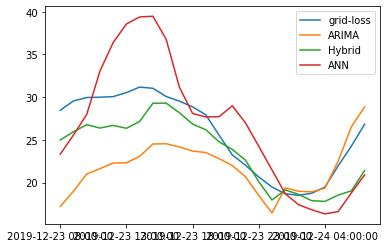

In [1668]:
temp[['grid-loss','ARIMA', 'Hybrid', 'ANN']].iloc[2400:2424].plot()

In [1669]:
mse = sum([temp['grid-loss']-temp['Hybrid']])